In [1]:
import networkx as nx
import numpy as np
import scipy 
import xmltodict
import matplotlib.pyplot as plt

In [6]:
def add_root_path(G, root_dict, root_id, split = 'left', root_deg = 0):
    
    # add node:
    for i, node in enumerate(root_dict):
        G.add_node((float(node['@coord_x']), float(node['@coord_y'])),
                        t = round(float(node['@coord_th'])),
                        root_id = root_id,
                        split = split,
                        root_deg = root_deg)
    
    # add edge:
    total_length = 0
    for i in range(len(root_dict)-1):
        u = (float(root_dict[i]['@coord_x']), float(root_dict[i]['@coord_y']))
        v =  (float(root_dict[i+1]['@coord_x']), float(root_dict[i+1]['@coord_y']))
        seg_length = scipy.spatial.distance.euclidean(u, v)
        G.add_edge(u, v, length = seg_length)  
        total_length += seg_length
    
    G.graph[f'lengths_{split}'].append(total_length)
    
    return

In [7]:
# convert xml to dict:
with open('61_graph_sr.rsml', 'r', encoding='utf-8') as file:
    rsml = file.read()
    
RSA_dict = xmltodict.parse(rsml)

In [8]:
G_root = nx.DiGraph()

G_root.graph['lengths_left'] = []
G_root.graph['lengths_right'] = []

# read left:
left = RSA_dict['rsml']['scene']['plant'][0]

# primary root:
primary = left['root']['geometry']['polyline']['point']
add_root_path(G_root, primary, root_id = left['root']['@ID'], split = 'left', root_deg = 0)

# lateral roots:
for lr in left['root']['root']:
    # for each lateral:
    lateral = lr['geometry']['polyline']['point']
    add_root_path(G_root, lateral, root_id = lr['@ID'], split = 'left', root_deg = 1)

    
# read right:
right = RSA_dict['rsml']['scene']['plant'][1]

# primary root:
primary = right['root']['geometry']['polyline']['point']
add_root_path(G_root, primary, root_id = right['root']['@ID'], split = 'right', root_deg = 0)

# lateral roots:
for lr in right['root']['root']:
    # for each lateral:
    lateral = lr['geometry']['polyline']['point']
    add_root_path(G_root, lateral, root_id = lr['@ID'], split = 'right', root_deg = 1)


In [9]:
G_root.graph['lengths_left']

[1033.1267393699818,
 120.51145729023096,
 88.11412612573642,
 89.96273587566195,
 52.448844277285595,
 58.12712291877929,
 70.56409853606772,
 13.625118402928551,
 22.442698703476722,
 23.08153743461713,
 31.41749077331666,
 19.679143857428578,
 18.920811381110564,
 14.601126159491539,
 10.12899020449196,
 10.65685424949238,
 14.919259774448749,
 6.0990195135927845,
 7.0710678118654755,
 2.236067980182937,
 11.49847350245616]

In [10]:
G_root.graph['lengths_right']

[1080.1135089878533,
 269.6161705471628,
 254.39993137637435,
 317.81123704227656,
 138.33343433706438,
 130.1587719150513,
 253.9563014426271,
 327.04349330215865,
 310.5188009816498,
 343.49076563073606,
 68.95346307346304,
 229.25173373584556,
 32.63433516285245,
 32.44038468871845,
 255.94947131190065,
 157.07699956820727,
 140.79816877900464,
 227.77309287570543,
 203.0550514074494,
 96.87538030775563,
 244.98377281189863,
 100.82975096714972,
 177.8539846290735,
 216.45553491680005,
 222.01962668116167,
 349.0921066194093,
 151.15119997237466,
 203.7821252354318,
 86.56423051470995,
 178.35212304437943,
 109.0875823867143,
 57.845729764518126,
 137.2051673983039,
 94.30678065184676,
 62.24835788639458,
 95.24157737232609,
 70.00186608189318,
 20.12899020449196,
 70.41194955659817,
 56.589322863446306,
 4.16227766016838,
 137.99097912125478]

In [44]:
print('left number LR:', len(G_root.graph['lengths_left']) - 1)
print('right number of LR:', len(G_root.graph['lengths_right']) - 1)
print('left total length(pixel):', round(np.array(G_root.graph['lengths_left']).sum()))
print('left total right(pixel):', round(np.array(G_root.graph['lengths_right']).sum()))

left number LR: 20
right number of LR: 41
left total length(pixel): 1719
left total right(pixel): 7717


In [11]:
pos = np.array(list(G_root.nodes()))

In [12]:
mins = np.min(pos, 0)
maxes = np.max(pos, 0)

G_root.graph['x_min'] = mins[0]
G_root.graph['y_min'] = mins[1]

G_root.graph['x_max'] = maxes[0]
G_root.graph['y_max'] = maxes[1]

G_root.graph['ratio'] = (maxes[0] - mins[0]) / (maxes[1] - mins[1])

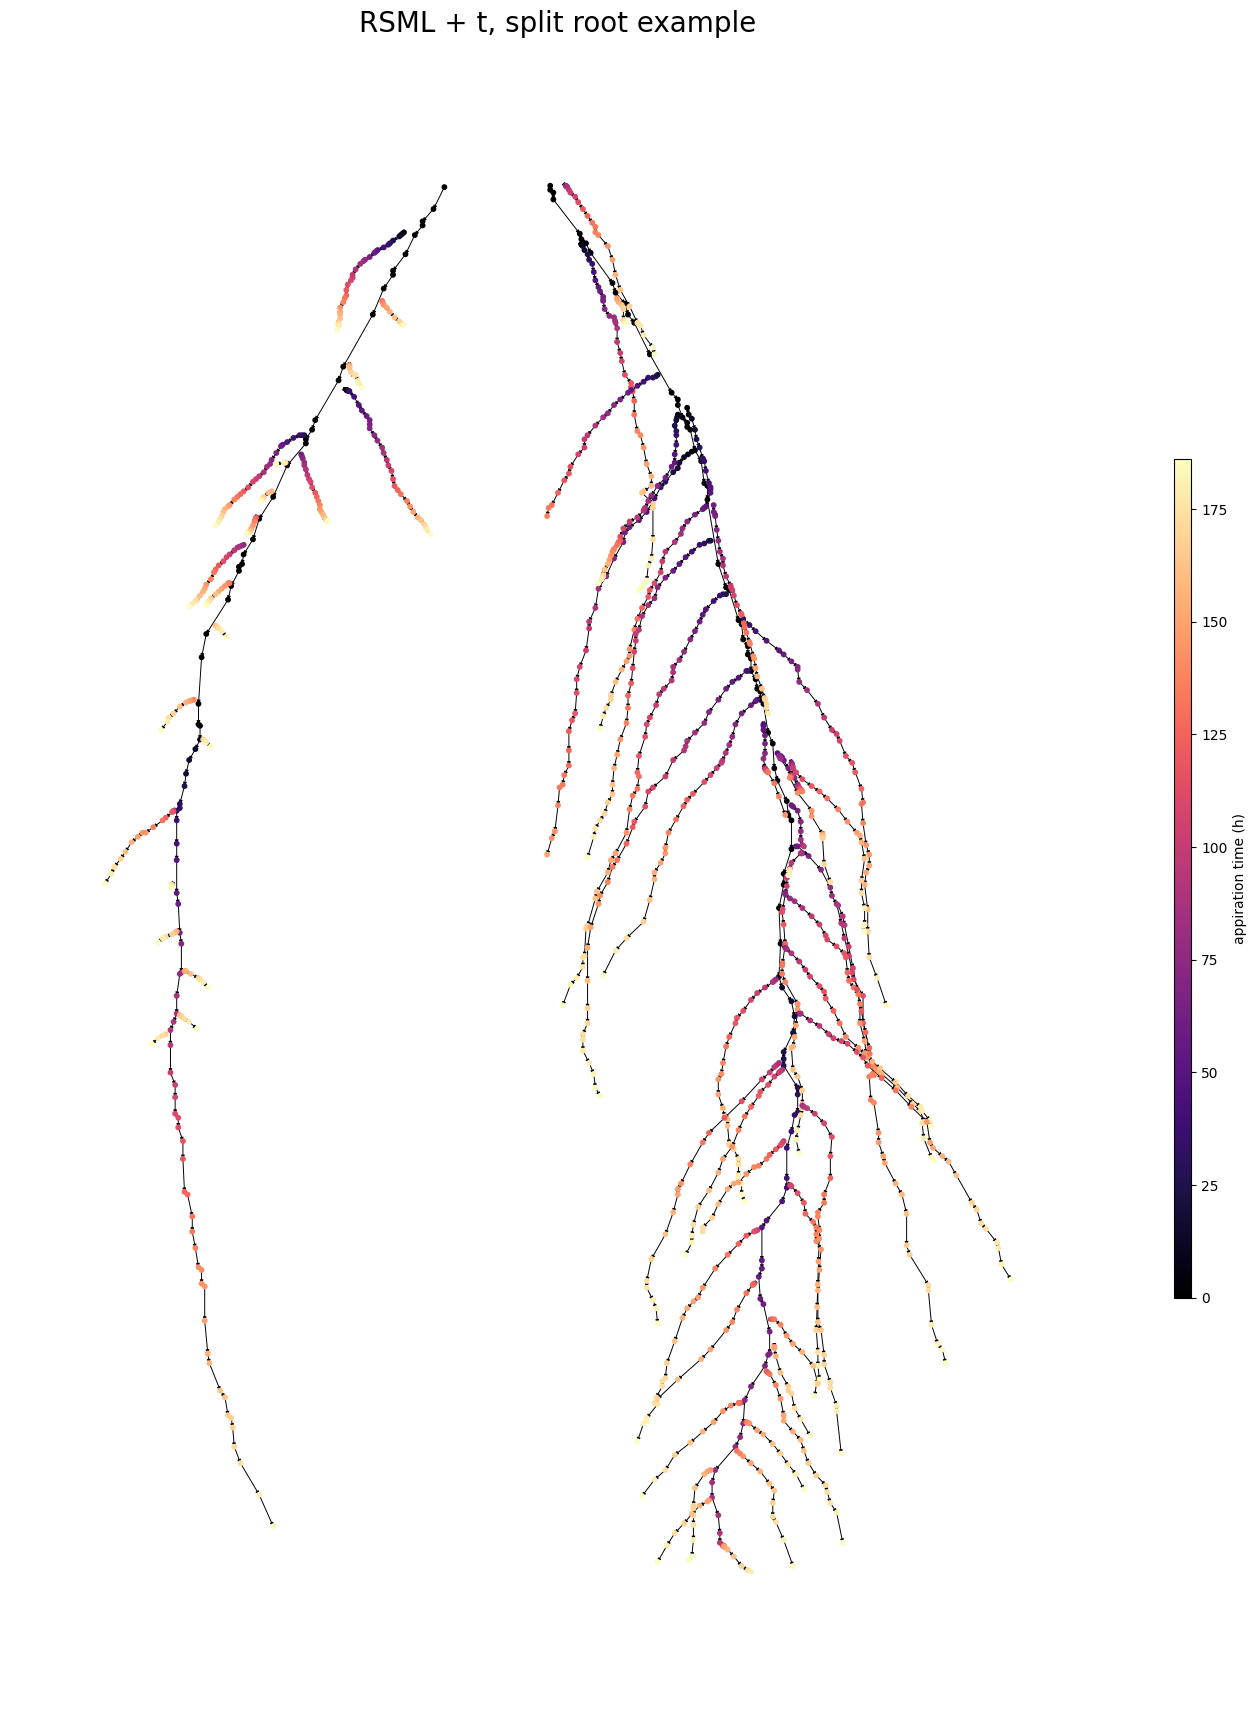

In [29]:
node_positions = {}
node_color = []

for node in G_root.nodes:
    node_positions[node] = ( node[0], - node[1])
    node_color.append(G_root.nodes[node]['t'])

fig, ax = plt.subplots(figsize = (14,10/G_root.graph['ratio']))

nx.draw(G_root, pos=node_positions, node_size = 0, width = .7, arrowsize = 5, ax = ax)
split_root_node = nx.draw_networkx_nodes(G_root, pos=node_positions, node_size= 10, node_color = node_color, ax = ax,  cmap=plt.cm.magma) 
ax.set_title('RSML + t, split root example', fontsize = 20)
plt.colorbar(split_root_node, aspect= 50, shrink = .5, label = 'appiration time (h)', orientation = 'vertical')
plt.tight_layout()
plt.show()  
fig.savefig('SR_time.pdf')

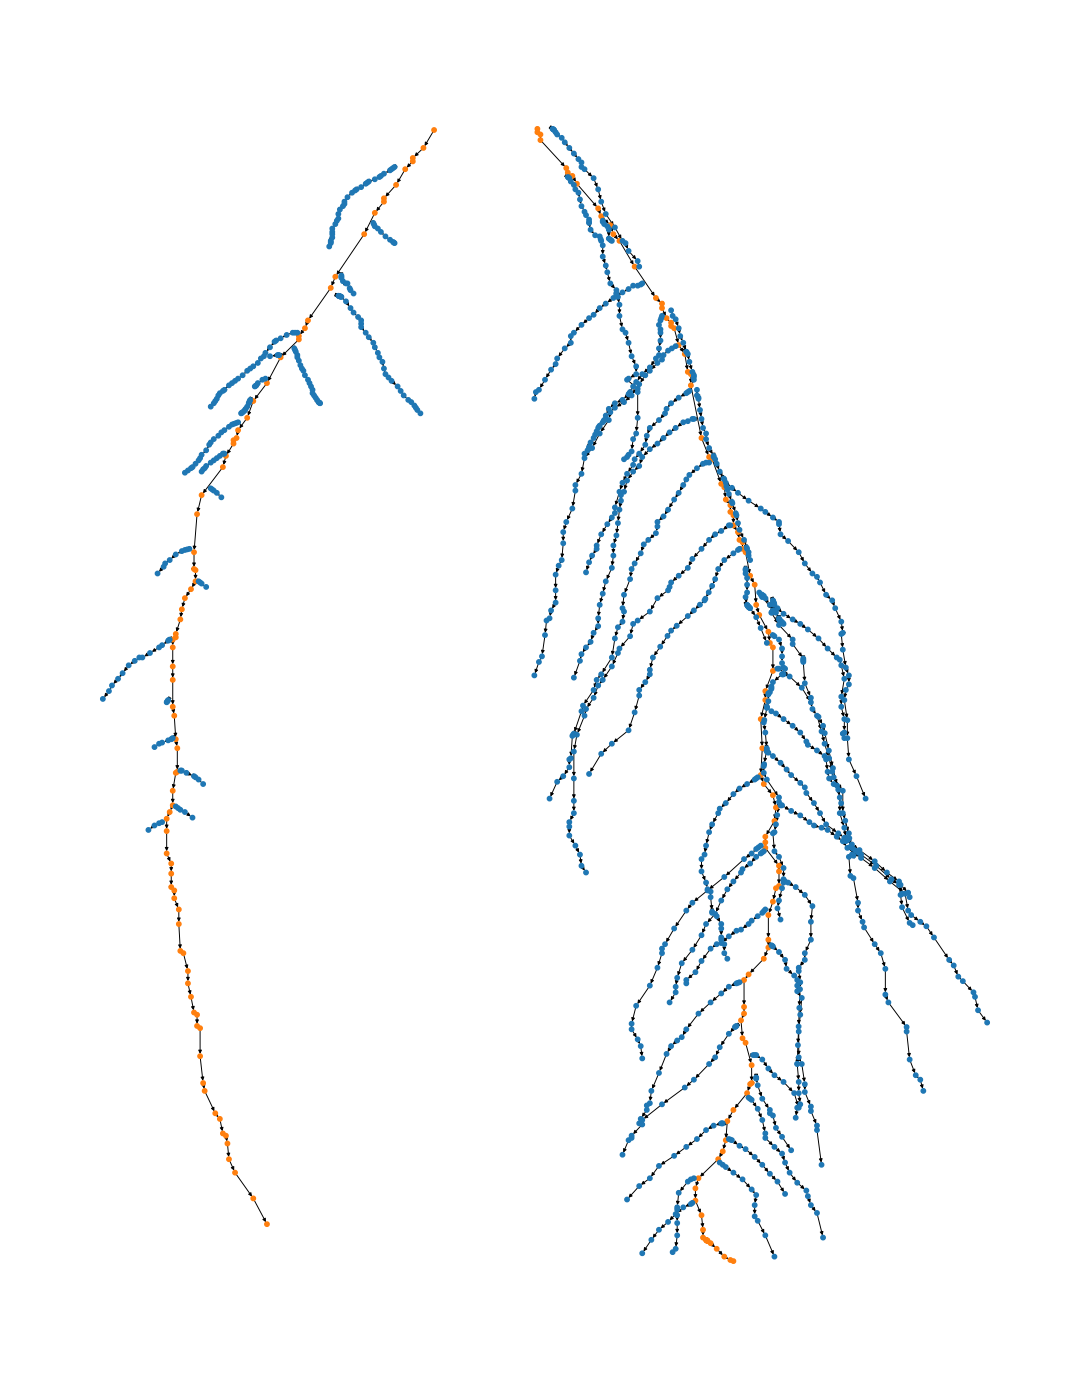

In [36]:

color_dict = {0:'C1',  1: 'C0'}
node_color = []

for node in G_root.nodes:
    node_positions[node] = ( node[0], -node[1])
    node_color.append(color_dict[G_root.nodes[node]['root_deg']])

fig, ax = plt.subplots(figsize = (11, 14))

nx.draw(G_root, pos=node_positions, node_size= 10,  width = .7, arrowsize = 5, node_color = node_color, ax = ax) 

plt.tight_layout()
plt.show()  

fig.savefig('SR_networkx.pdf')

In [159]:
H_left = G_left.to_undirected()
nx.number_connected_components(H_left)

28